# Setup environment

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
%cd drive/MyDrive/'Colab Notebooks'/Thesis/PeerRead/code/accept_classify/

/content/drive/MyDrive/Colab Notebooks/Thesis/PeerRead/code/accept_classify


# Import library and Load Data


In [6]:
path = '../../my_data/Figures/01-Paper-Acceptance-'

In [7]:
import json, pickle, os
import pandas as pd
import nltk
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, plot_roc_curve

sns.set_context("talk", font_scale=2)

In [8]:
with open('../../my_data/01-Paper-Acceptance/paper_review', "rb") as f:
  all_data=pickle.load(f)

train_data, train_target, val_data, val_target, test_data, test_target = all_data

# BERT

In [9]:
with open('../../my_data/01-Paper-Acceptance/bert_outcome-16', "rb") as f:
    outcome_bert=pickle.load(f) 
df_bert=pd.DataFrame(outcome_bert)

In [10]:
df_bert['avg'] = df_bert.apply(lambda row: (row['roc_auc']+row['accuracy'])/2, axis=1)


In [11]:
df_bert.sort_values('avg',ascending=False).head(5)

,roc_auc,accuracy,probs,fpr,tpr,avg
7,0.695652,0.710526,"[[0.5445369, 0.45546308], [0.4935079, 0.506492...","[0.0, 0.0, 0.0, 0.08695652173913043, 0.0869565...","[0.0, 0.06666666666666667, 0.3333333333333333,...",0.703089
0,0.713043,0.657895,"[[0.59778756, 0.40221244], [0.56003416, 0.4399...","[0.0, 0.0, 0.0, 0.043478260869565216, 0.043478...","[0.0, 0.06666666666666667, 0.2, 0.2, 0.3333333...",0.685469
9,0.692754,0.657895,"[[0.5382657, 0.4617343], [0.577519, 0.42248103...","[0.0, 0.0, 0.0, 0.08695652173913043, 0.0869565...","[0.0, 0.06666666666666667, 0.26666666666666666...",0.675324
6,0.684058,0.631579,"[[0.5489621, 0.4510379], [0.60141, 0.3985901],...","[0.0, 0.0, 0.0, 0.08695652173913043, 0.0869565...","[0.0, 0.06666666666666667, 0.26666666666666666...",0.657818
2,0.614493,0.684211,"[[0.6619964, 0.33800364], [0.49938244, 0.50061...","[0.0, 0.0, 0.0, 0.043478260869565216, 0.043478...","[0.0, 0.06666666666666667, 0.13333333333333333...",0.649352


In [12]:
PROBS_b = np.array([out['probs'] for out in outcome_bert])
ACC_b   = np.array([out['accuracy'] for out in outcome_bert])
FPR_b   = np.array([out['fpr'] for out in outcome_bert])
TPR_b   = np.array([out['tpr'] for out in outcome_bert])
AUC_b   = np.array([out['roc_auc'] for out in outcome_bert])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  after removing the cwd from sys.path.


In [14]:
cf_matrix_b = confusion_matrix(test_target, PROBS_b[7].argmax(axis=1))
print(cf_matrix_b)

[[23  0]
 [11  4]]


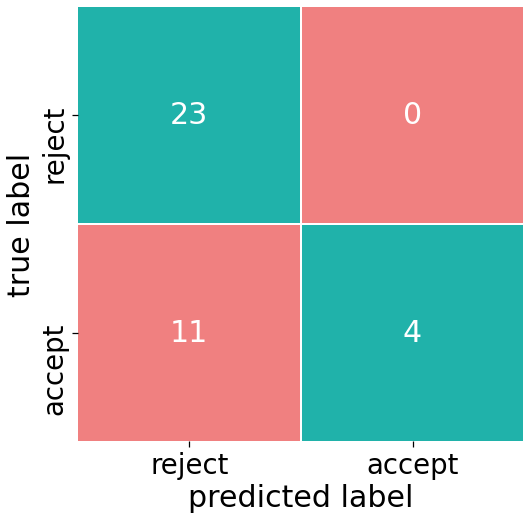

In [ ]:
from matplotlib import colors
sns.set_context("notebook", font_scale=2.5)
fig,ax = plt.subplots(figsize = (8,8))
cmap = colors.ListedColormap(['lightcoral','lightseagreen','lightcoral','lightseagreen'])
bounds=[0, 3, 5, 12, 20]
norm = colors.BoundaryNorm(bounds, cmap.N)
heatmap = sns.heatmap(cf_matrix_b, annot=True, 
           cmap=cmap, norm=norm, linewidths=.5,  cbar=False)



plt.xlabel("predicted label") 
plt.ylabel("true label")
plt.xticks([0.5, 1.5], ['reject', 'accept'])  
plt.yticks([0.5, 1.5], ['reject', 'accept']) 
plt.savefig(path+'bert_confusion-matrix',  dpi=400, bbox_inches = 'tight', pad_inches = 0 )


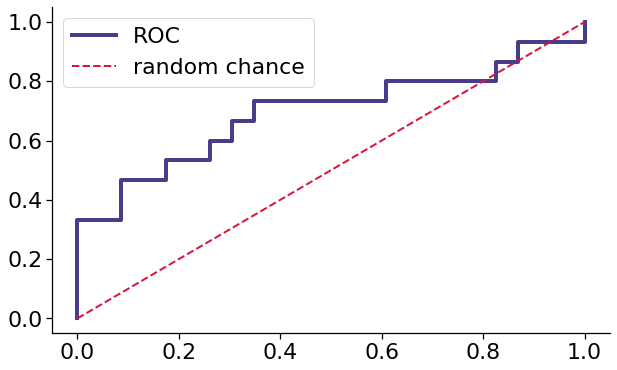

In [ ]:
sns.set_context("notebook", font_scale=2)
fig,ax=plt.subplots(figsize = (10,6))

ax.plot(FPR_b[7], TPR_b[7],label='ROC', color='darkslateblue', lw=4)
ax.plot([0, 1], [0, 1],label='random chance', color='crimson', lw=2, linestyle='dashed')
#plt.xlim(-0.5,10)
#plt.ylim(0,2)
#plt.xlabel('epochs')
#plt.ylabel('loss')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

#plt.rc({'font.size': 10})

ax.legend()

plt.savefig(path+'bert_ROC',  dpi=400, bbox_inches = 'tight', pad_inches = 0 )

In [ ]:
from sklearn.metrics import classification_report
target_names = ['Reject', 'Accept']
print(classification_report(test_target, PROBS_b[7].argmax(axis=1), target_names=target_names))

              precision    recall  f1-score   support

      Reject       0.68      1.00      0.81        23
      Accept       1.00      0.27      0.42        15

    accuracy                           0.71        38
   macro avg       0.84      0.63      0.61        38
weighted avg       0.80      0.71      0.65        38



In [ ]:
df_bert.describe()

,roc_auc,accuracy,avg
count,10.000000,10.000000,10.000000
mean,0.631304,0.642105,0.636705
std,0.066094,0.037627,0.045941
min,0.513043,0.605263,0.559153
25%,0.586232,0.605263,0.603051
50%,0.633333,0.644737,0.639035
75%,0.690580,0.657895,0.670948
max,0.713043,0.710526,0.703089


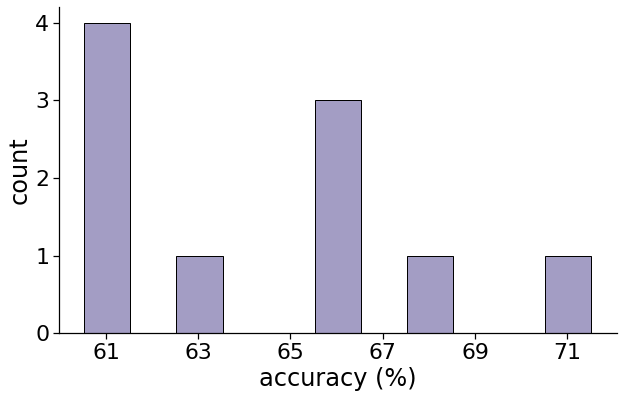

In [ ]:
sns.set_context("notebook", font_scale=2)
fig, ax = plt.subplots(figsize=(10,6))
sns.histplot(x=ACC_b, alpha=0.5, color= 'darkslateblue', ax=ax, binwidth=0.01)
sns.despine()
plt.ylabel('count')
plt.xlabel('accuracy (%)')
ax.set_xticks([0.61,0.63, 0.65, 0.67, 0.69, 0.71])
ax.set_xticklabels(['61','63','65','67', 69, 71])
plt.savefig(path+'bert_ACC',  dpi=400, bbox_inches = 'tight', pad_inches = 0 )

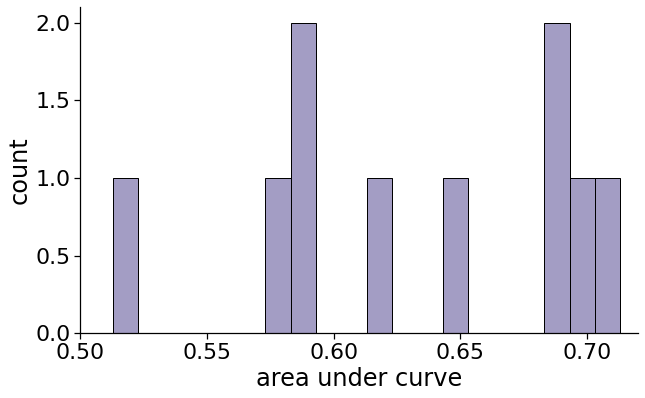

In [ ]:
sns.set_context("notebook", font_scale=2)
fig, ax = plt.subplots(figsize=(10,6))
sns.histplot(x=AUC_b, alpha=0.5, color= 'darkslateblue', ax=ax, binwidth=0.01)
sns.despine()
plt.ylabel('count')
plt.xlabel('area under curve')
plt.xlim(0.50,0.72)
plt.savefig(path+'bert_AUC',  dpi=400, bbox_inches = 'tight', pad_inches = 0 )

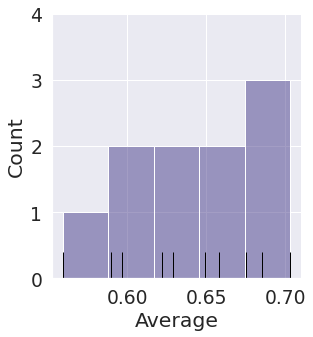

In [ ]:
sns.displot(data=df_bert, x='avg', alpha=0.5, color='darkslateblue')
sns.rugplot(data=df_bert, x='avg',  height=.1, color='black')
plt.ylabel('Count')
plt.xlabel('Average')
plt.ylim(0,4)
plt.savefig(path+'bert_Avg',  dpi=400, bbox_inches = 'tight', pad_inches = 0 )

In [181]:
data=PROBS_b[7]
outcome=np.argmax(data,axis=1)
probs = [data[i,outcome[i]] for i in range(len(data))]
outcome_str = list(map(lambda x: 'accept' if x==1 else 'reject', outcome))

In [182]:
df_ar = pd.DataFrame(np.vstack((probs,outcome_str)).T,columns=['probs','outcome'])

In [183]:
df_ar["probs"] = pd.to_numeric(df_ar["probs"])

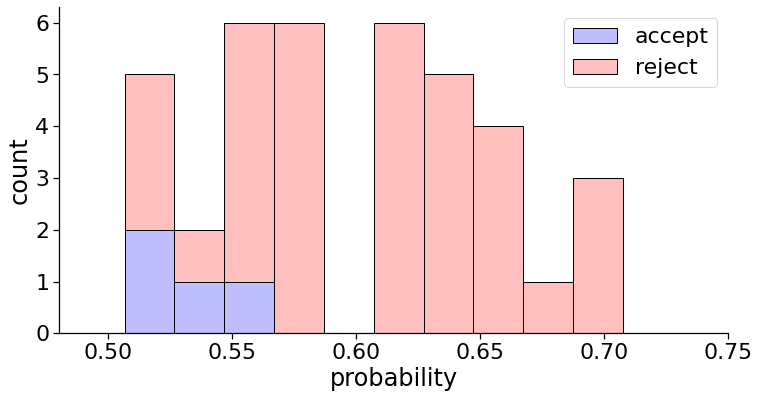

In [187]:
sns.set_context("notebook", font_scale=2)
fig, ax = plt.subplots(figsize=(12,6))
sns.histplot(data=df_ar, x='probs', hue='outcome', multiple='stack', palette='bwr_r', bins=10,  ax=ax)
sns.despine()
plt.ylabel('count')
plt.xlabel('probability')
plt.legend(['accept', 'reject'])
plt.xlim(0.48, 0.75)
plt.savefig(path+'bert_prob',  dpi=400, bbox_inches = 'tight', pad_inches = 0 )

# SciBert

In [38]:
with open('../../my_data/01-Paper-Acceptance/scibert_outcome-16', "rb") as f:
    outcome_scibert=pickle.load(f) 
df_scibert=pd.DataFrame(outcome_scibert)

In [39]:
df_scibert['avg'] = df_scibert.apply(lambda row: (row['roc_auc']+row['accuracy'])/2, axis=1)

In [40]:
df_scibert.sort_values('avg',ascending=False).head(5)

,roc_auc,accuracy,probs,fpr,tpr,avg
2,0.695652,0.657895,"[[0.7428801, 0.2571199], [0.45442626, 0.545573...","[0.0, 0.0, 0.043478260869565216, 0.04347826086...","[0.0, 0.06666666666666667, 0.06666666666666667...",0.676773
6,0.666667,0.684211,"[[0.7148482, 0.2851518], [0.48102498, 0.518975...","[0.0, 0.0, 0.0, 0.08695652173913043, 0.0869565...","[0.0, 0.06666666666666667, 0.26666666666666666...",0.675439
5,0.617391,0.657895,"[[0.81610864, 0.18389134], [0.3380404, 0.66195...","[0.0, 0.0, 0.0, 0.043478260869565216, 0.043478...","[0.0, 0.06666666666666667, 0.13333333333333333...",0.637643
8,0.568116,0.631579,"[[0.8847116, 0.11528838], [0.35660198, 0.64339...","[0.0, 0.0, 0.08695652173913043, 0.086956521739...","[0.0, 0.06666666666666667, 0.06666666666666667...",0.599847
9,0.542029,0.605263,"[[0.89586467, 0.104135364], [0.40193307, 0.598...","[0.0, 0.0, 0.043478260869565216, 0.04347826086...","[0.0, 0.06666666666666667, 0.06666666666666667...",0.573646


In [42]:
PROBS = np.array([out['probs'] for out in outcome_scibert])
ACC   = np.array([out['accuracy'] for out in outcome_scibert])
FPR   = np.array([out['fpr'] for out in outcome_scibert])
TPR   = np.array([out['tpr'] for out in outcome_scibert])
AUC   = np.array([out['roc_auc'] for out in outcome_scibert])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  after removing the cwd from sys.path.


In [43]:
cf_matrix = confusion_matrix(test_target, PROBS[2].argmax(axis=1))
print(cf_matrix)

[[18  5]
 [ 8  7]]


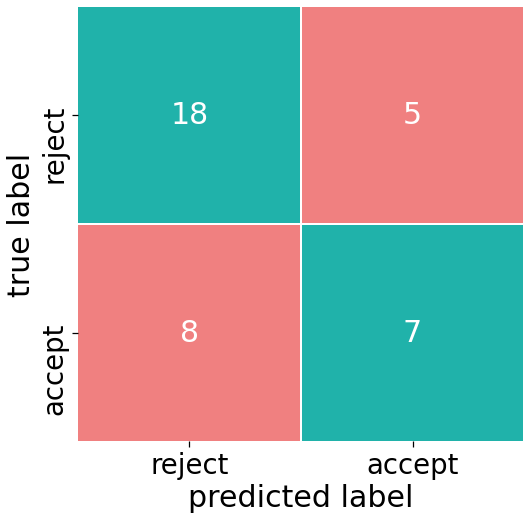

In [56]:
from matplotlib import colors
sns.set_context("notebook", font_scale=2.5)
fig,ax = plt.subplots(figsize = (8,8))
cmap = colors.ListedColormap(['lightcoral','lightseagreen','lightcoral','lightseagreen'])
bounds=[0, 5.5, 7.5, 10, 12]
norm = colors.BoundaryNorm(bounds, cmap.N)
heatmap = sns.heatmap(cf_matrix, annot=True, 
           cmap=cmap, norm=norm, linewidths=.5,  cbar=False)


plt.xlabel("predicted label") 
plt.ylabel("true label")
plt.xticks([0.5, 1.5], ['reject', 'accept'])  
plt.yticks([0.5, 1.5], ['reject', 'accept']) 
plt.savefig(path+'scibert_confusion-matrix',  dpi=400, bbox_inches = 'tight', pad_inches = 0 )


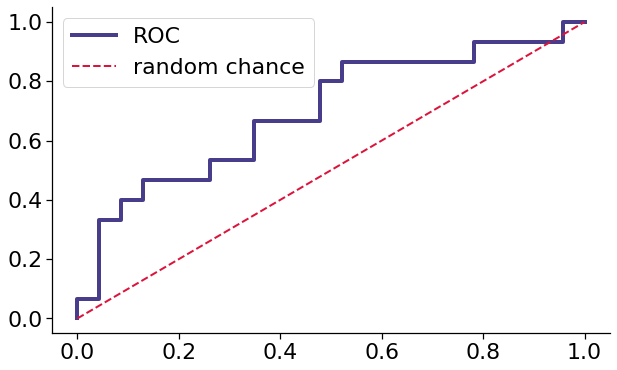

In [188]:
sns.set_context("notebook", font_scale=2)
fig,ax=plt.subplots(figsize = (10,6))

ax.plot(FPR[2], TPR[2],label='ROC', color='darkslateblue', lw=4)
ax.plot([0, 1], [0, 1],label='random chance', color='crimson', lw=2, linestyle='dashed')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend()

plt.savefig(path+'scibert_ROC',  dpi=400, bbox_inches = 'tight', pad_inches = 0 )

In [189]:
from sklearn.metrics import classification_report
target_names = ['Reject', 'Accept']
print(classification_report(test_target, PROBS[2].argmax(axis=1), target_names=target_names))

              precision    recall  f1-score   support

      Reject       0.69      0.78      0.73        23
      Accept       0.58      0.47      0.52        15

    accuracy                           0.66        38
   macro avg       0.64      0.62      0.63        38
weighted avg       0.65      0.66      0.65        38



In [ ]:
df_scibert.describe()

,roc_auc,accuracy,avg
count,10.000000,10.000000,10.000000
mean,0.575362,0.610526,0.592944
std,0.064122,0.049310,0.052403
min,0.510145,0.526316,0.542982
25%,0.534783,0.585526,0.549838
50%,0.555072,0.605263,0.572921
75%,0.605072,0.651316,0.628194
max,0.695652,0.684211,0.676773


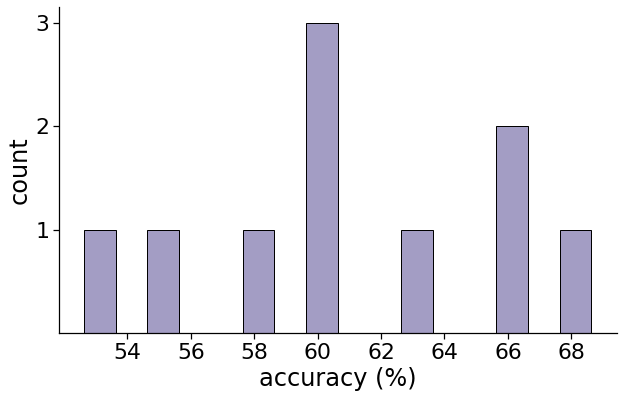

In [68]:
sns.set_context("notebook", font_scale=2)
fig, ax = plt.subplots(figsize=(10,6))
sns.histplot(x=ACC, alpha=0.5, color= 'darkslateblue', ax=ax, binwidth=0.01)
sns.despine()
plt.ylabel('count')
plt.xlabel('accuracy (%)')
ax.set_yticks([1,2,3])
ax.set_xticks([0.54, 0.56, 0.58, 0.60, 0.62, 0.64, 0.66, 0.68])
ax.set_xticklabels(['54','56','58','60', '62', '64', '66', '68'])
plt.savefig(path+'scibert_ACC',  dpi=400, bbox_inches = 'tight', pad_inches = 0 )

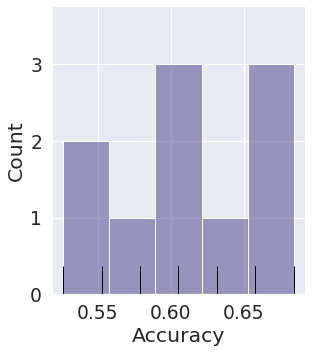

In [ ]:
sns.displot(x=ACC, alpha=0.5, color= 'darkslateblue')
sns.rugplot(x=ACC, height=.1, color='black')
plt.ylabel('Count')
plt.xlabel('Accuracy')
plt.savefig(path+'scibert_ACC',  dpi=400, bbox_inches = 'tight', pad_inches = 0)

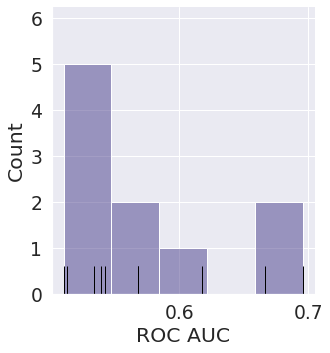

In [ ]:
sns.displot(x=AUC, alpha=0.5, color='darkslateblue')
sns.rugplot(x=AUC, height=.1, color='black')
plt.ylabel('Count')
plt.xlabel('ROC AUC')
plt.savefig(path+'scibert_AUC',  dpi=400, bbox_inches = 'tight', pad_inches = 0 )

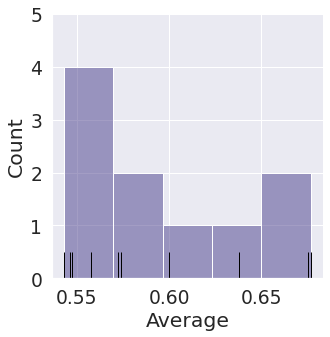

In [ ]:
sns.displot(data=df_scibert, x='avg', alpha=0.5, color='darkslateblue')
sns.rugplot(data=df_scibert, x='avg',  height=.1, color='black')
plt.ylabel('Count')
plt.xlabel('Average')
plt.savefig(path+'scibert_Avg',  dpi=400, bbox_inches = 'tight', pad_inches = 0 )

In [145]:
data=PROBS[2]
outcome=np.argmax(data,axis=1)
probs = [data[i,outcome[i]] for i in range(len(data))]
outcome_str = list(map(lambda x: 'accept' if x==1 else 'reject', outcome))

In [152]:
df_ar = pd.DataFrame(np.vstack((probs,outcome_str)).T,columns=['probs','outcome'])

In [162]:
df_ar

,probs,outcome
0,0.742880,reject
1,0.545574,accept
2,0.681914,accept
3,0.903656,reject
4,0.619079,reject
5,0.848277,reject
6,0.549277,accept
7,0.656158,accept
8,0.707818,reject
9,0.726180,accept


In [159]:
df_ar["probs"] = pd.to_numeric(df_ar["probs"])

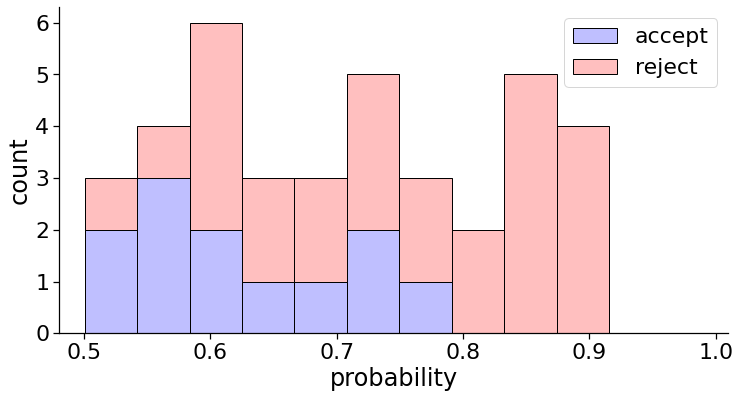

In [180]:
sns.set_context("notebook", font_scale=2)
fig, ax = plt.subplots(figsize=(12,6))
sns.histplot(data=df_ar, x='probs', hue='outcome', multiple='stack', palette='bwr_r', bins=10,  ax=ax)
sns.despine()
plt.ylabel('count')
plt.xlabel('probability')
plt.legend(['accept', 'reject'])
plt.xlim(0.48, 1.01)
plt.savefig(path+'scibert_prob',  dpi=400, bbox_inches = 'tight', pad_inches = 0 )